In [1]:
import pandas as pd
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
# !pip install pyLDAvis

In [3]:
review_df = pd.read_csv('./Dataset/train_all_noun.csv')
review_df.head()

,recipe_id,name,review,clean_review,noun_review
0,5315,icy holiday punch,I brought this to an office holiday party and ...,"['brought', 'office', 'holiday', 'party', 'eve...","['office', 'holiday', 'party']"
1,8661,oliveau salad dressing,Good recipe and easy to make. I found it a li...,"['good', 'recipe', 'easy', 'make', 'found', 'l...","['make', 'salad', 'wine', 'dilute']"
2,10859,broccoli cauliflower and rice casserole,This is a nice casserole. It is very easy to ...,"['nice', 'casserole', 'easy', 'put', 'together']","['casserole', 'put']"
3,902,microwaved garlic mushroom rolls,Very easy to make for a lunch. I served it co...,"['easy', 'make', 'lunch', 'served', 'cold', 's...","['lunch', 'sandwich', 'cheese', 'cheese', 'che..."
4,8549,taverns,A friend of mine loves ketchup so he loved thi...,"['friend', 'mine', 'loves', 'ketchup', 'loved'...","['friend', 'ketchup', 'ketchup', 'lot', 'flavo..."


# Create Corpus

In [4]:
# change noun review to list
def str_to_list(text):
    text = text[1:len(text)-1]
    text_list = text.split(',')
    text_list = [text.strip()[1:-1] for text in text_list]
    return text_list

In [5]:
data_lemmatized = review_df['noun_review'].tolist()
data_lemmatized = [str_to_list(text) for text in data_lemmatized]
data_lemmatized[:10]

[['office', 'holiday', 'party'],
 ['make', 'salad', 'wine', 'dilute'],
 ['casserole', 'put'],
 ['lunch', 'sandwich', 'cheese', 'cheese', 'cheddar'],
 ['friend', 'ketchup', 'ketchup', 'lot', 'flavour'],
 ['coffee', 'dessert', 'night', 'dessert'],
 ['good', 'pie', 'shell', 'whip', 'town', 'guest'],
 ['potato'],
 ['beat', 'stuff'],
 ['pm', 'stuff']]

In [6]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [7]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'holiday'), (1, 'office'), (2, 'party'), (3, 'dilute'), (4, 'make'), (5, 'salad'), (6, 'wine'), (7, 'casserole'), (8, 'put'), (9, 'cheddar'), (10, 'cheese'), (11, 'lunch'), (12, 'sandwich'), (13, 'flavour'), (14, 'friend'), (15, 'ketchup'), (16, 'lot'), (17, 'coffee'), (18, 'dessert'), (19, 'night'), (20, 'good'), (21, 'guest'), (22, 'pie'), (23, 'shell'), (24, 'town'), (25, 'whip'), (26, 'potato'), (27, 'beat'), (28, 'stuff'), (29, 'pm'), (30, 'share'), (31, 'versitile'), (32, 'blueberry'), (33, 'lemon'), (34, 'week'), (35, 'chicken'), (36, 'marinade'), (37, 'sauce'), (38, 'doubt'), (39, 'mustard'), (40, 'desert'), (41, 'bean'), (42, 'corn'), (43, 'day'), (44, 'rice'), (45, 'side'), (46, 'winner'), (47, 'bergy'), (48, 'onion'), (49, 'spud')]

Total Vocabulary Size: 7710


# Building LDA Model

## Hyperparameter Tuning for LDA Model

In [8]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    log_perplexity = lda_model.log_perplexity(corpus)
    perplexity = 2**(-log_perplexity)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [9]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.3458734554410878
Perplexity Score:  109.42107825993301

topic number:  3
Coherence Score:  0.37828672544125247
Perplexity Score:  111.19109443784984

topic number:  4
Coherence Score:  0.41485451637530724
Perplexity Score:  113.38025648147514

topic number:  5
Coherence Score:  0.40748211026911524
Perplexity Score:  117.5416032938

topic number:  6
Coherence Score:  0.44869169258323854
Perplexity Score:  120.22151255494565

topic number:  7
Coherence Score:  0.42484367252360117
Perplexity Score:  124.06002055266394

topic number:  8
Coherence Score:  0.3925654804963865
Perplexity Score:  126.75147834427898

topic number:  9
Coherence Score:  0.43612043891163493
Perplexity Score:  131.7374103774796

topic number:  10
Coherence Score:  0.4356327893448376
Perplexity Score:  141.97183251756968

topic number:  11
Coherence Score:  0.44171394556994525
Perplexity Score:  160.38137607757133

topic number:  12
Coherence Score:  0.40064204830208094
Perplexity

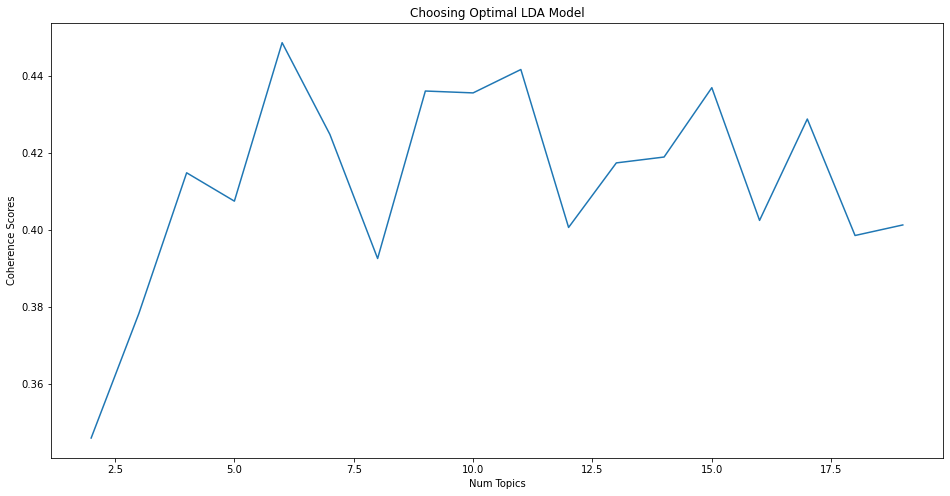

In [10]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

## Final LDA Model

In [11]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=6, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [12]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.039*"cheese" + 0.035*"soup" + 0.031*"pepper" + 0.026*"onion" + '
  '0.023*"salt" + 0.021*"tomato" + 0.016*"cream" + 0.015*"sauce" + '
  '0.015*"flavor" + 0.014*"garlic"'),
 (1,
  '0.025*"sugar" + 0.021*"tag" + 0.020*"bread" + 0.020*"cookie" + '
  '0.019*"chocolate" + 0.018*"cake" + 0.016*"cream" + 0.015*"butter" + '
  '0.014*"game" + 0.013*"milk"'),
 (2,
  '0.043*"star" + 0.027*"food" + 0.023*"family" + 0.020*"day" + '
  '0.019*"comfort" + 0.018*"dinner" + 0.018*"year" + 0.017*"kid" + '
  '0.014*"rating" + 0.013*"dh"'),
 (3,
  '0.063*"chicken" + 0.053*"sauce" + 0.025*"oil" + 0.020*"pac" + 0.017*"chef" '
  '+ 0.017*"rice" + 0.016*"hour" + 0.016*"spring" + 0.016*"potato" + '
  '0.015*"flavor"'),
 (4,
  '0.046*"salad" + 0.026*"flavor" + 0.021*"flavour" + 0.020*"lunch" + '
  '0.020*"tag" + 0.018*"bean" + 0.017*"love" + 0.015*"meal" + 0.015*"rice" + '
  '0.013*"ingredient"'),
 (5,
  '0.035*"juice" + 0.030*"lemon" + 0.023*"drink" + 0.021*"flavor" + '
  '0.017*"lime" + 0.015*"ginger

In [13]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [14]:
doc_num, topic_num, prob = [], [], []
print(lda_model.get_document_topics(corpus))
for n in range(len(review_df)):
    get_document_topics = lda_model.get_document_topics(corpus[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])

In [15]:
review_df['Doc'] = doc_num
review_df['Topic'] = topic_num
review_df['Probability'] = prob

In [16]:
df_final = review_df[['recipe_id', 'name', 'review', 'Doc', 'Topic', 'Probability']]
df_final

,recipe_id,name,review,Doc,Topic,Probability
0,5315,icy holiday punch,I brought this to an office holiday party and ...,0,1,0.470206
1,8661,oliveau salad dressing,Good recipe and easy to make. I found it a li...,1,4,0.578600
2,10859,broccoli cauliflower and rice casserole,This is a nice casserole. It is very easy to ...,2,0,0.720663
3,902,microwaved garlic mushroom rolls,Very easy to make for a lunch. I served it co...,3,0,0.860331
4,8549,taverns,A friend of mine loves ketchup so he loved thi...,4,0,0.459346
...,...,...,...,...,...,...
65179,392968,cinnamon brownie cupcakes,These are absolutely to-die-for! Made as direc...,65179,1,0.658637
65180,297946,steamed vegetables with john s dipping sauce,Very good way to add some extra taste to basic...,65180,3,0.394803
65181,410482,the world s fastest chocolate sour cream cake ...,This cake really is super easy and also super ...,65181,1,0.864103
65182,347632,kick butt spaghetti sauce out of a jar,"Yes, I find that jarred spaghetti sauce needs ...",65182,0,0.563376


## Model Evaluation

In [17]:
# Compute Perplexity
log_perplexity = lda_model.log_perplexity(corpus)
perplexity = 2**(-log_perplexity)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  120.63056005200067
Coherence Score:  0.441252176562618


In [23]:
# df_final.to_csv("topic_modelling_all_noun.csv", index=False)

# Visualisation

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.031113  0.017349       1        1  24.200457
0      0.158169 -0.105444       2        1  20.631821
3      0.158018 -0.107526       3        1  18.948435
4      0.003547 -0.036535       4        1  14.379516
2     -0.333653 -0.117712       5        1  11.615339
5     -0.017195  0.349868       6        1  10.224431, topic_info=            Term         Freq        Total Category  logprob  loglift
35       chicken  7628.000000  7628.000000  Default  30.0000  30.0000
37         sauce  8438.000000  8438.000000  Default  29.0000  29.0000
5          salad  4233.000000  4233.000000  Default  28.0000  28.0000
10        cheese  5088.000000  5088.000000  Default  27.0000  27.0000
72          soup  4667.000000  4667.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
13       flavour   420.072405  2395.172986   Topic6  -5.0476   0.5396
204  combination   410.434115  2220.895306   Topic6  -5.0708   0.5919
164        water   401.735212  2380.851401   Topic6  -5.0922   0.5010
26        potato   411.887357  4481.177218   Topic6  -5.0672  -0.1065
43           day   394.950675  3528.631221   Topic6  -5.1092   0.0905

[362 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
160       6  0.999070            
846       4  0.995319  adjustment
129       5  0.998071       adult
341       1  0.998478      almond
179       1  0.213694      amount
...     ...       ...         ...
5457      2  0.007721         zwt
5457      3  0.050739         zwt
5457      4  0.253694         zwt
5457      5  0.198543         zwt
5457      6  0.415837         zwt

[557 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 5, 3, 6])

## Word Count of Topic Keywords

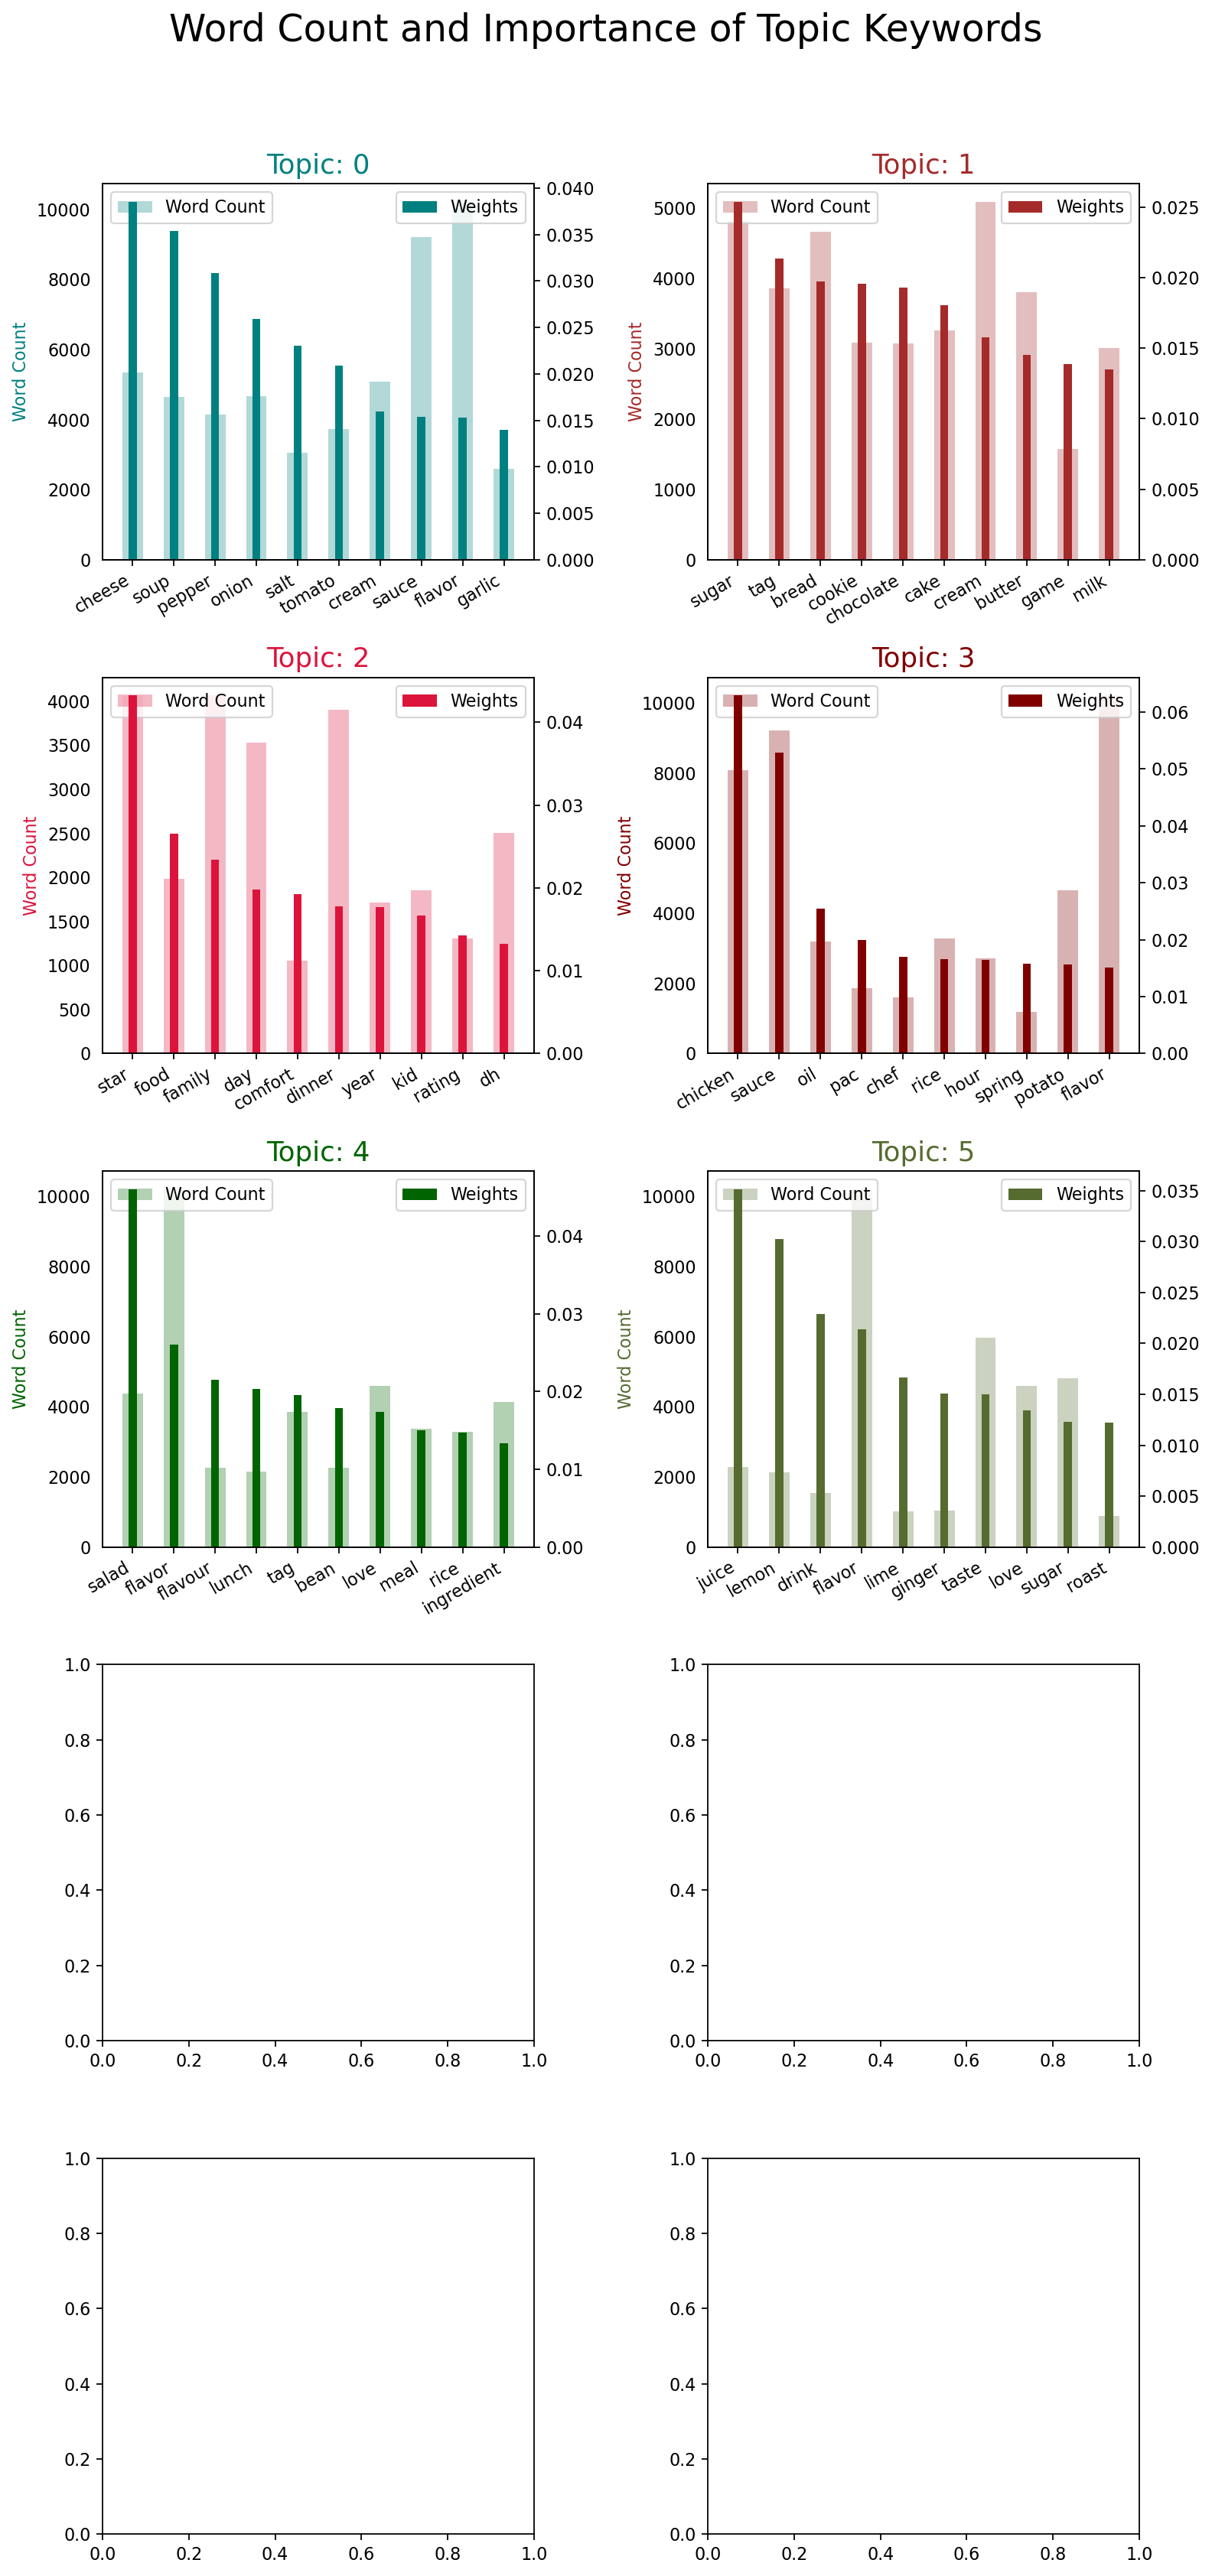

In [19]:
from collections import Counter

num_topics = 6

topics = lda_model.show_topics(num_topics=num_topics, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(10,20), dpi=160)
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > num_topics - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# Extract features (User preferences)

In [20]:
all_topics = lda_model.show_topics(num_topics=num_topics, formatted=False)
all_topics[0]

(0,
 [('cheese', 0.038541812),
  ('soup', 0.035372697),
  ('pepper', 0.030861912),
  ('onion', 0.02588928),
  ('salt', 0.023079678),
  ('tomato', 0.020876477),
  ('cream', 0.015953433),
  ('sauce', 0.01541041),
  ('flavor', 0.015270161),
  ('garlic', 0.014015424)])

In [21]:
all_terms = []
topics_cnt = []
for topic, term in all_topics:
    topics_cnt.append(topic)
    for t in term:
        if t[0] not in all_terms and t[0] != "":
            all_terms.append(t[0])
        
print(topics_cnt)
print()
print(all_terms)

[0, 1, 2, 3, 4, 5]

['cheese', 'soup', 'pepper', 'onion', 'salt', 'tomato', 'cream', 'sauce', 'flavor', 'garlic', 'sugar', 'tag', 'bread', 'cookie', 'chocolate', 'cake', 'butter', 'game', 'milk', 'star', 'food', 'family', 'day', 'comfort', 'dinner', 'year', 'kid', 'rating', 'dh', 'chicken', 'oil', 'pac', 'chef', 'rice', 'hour', 'spring', 'potato', 'salad', 'flavour', 'lunch', 'bean', 'love', 'meal', 'ingredient', 'juice', 'lemon', 'drink', 'lime', 'ginger', 'taste', 'roast']


Extracted features: 

['pepper', 'tomato', 'onion', 'salt', 'garlic', 'powder', 'veggie', 'ground', 'chili', 'mushroom', 'sugar', 'cake', 'tag', 'flour', 'game', 'cream', 'muffin', 'apple', 'vanilla', 'holiday', 'food', 'drink', 'comfort', 'lime', 'coffee', 'burger', 'morning', 'summer', 'breakfast', 'tea', 'sauce', 'chicken', 'breast', 'pasta', 'rice', 'noodle', 'flavor', 'soy', 'hubby', 'broccoli', 'flavour', 'year', 'kid', 'review', 'husband', 'lol', 'event', 'market', 'prepare', 'bread', 'dough', 'loaf', 'roll', 'sandwich', 'pan', 'texture', 'pizza', 'biscuit', 'inch', 'star', 'chef', 'dh', 'rating', 'taste', 'sharing', 'shrimp', 'store', 'system', 'foil', 'cookie', 'chocolate', 'butter', 'chip', 'milk', 'baking', 'peanut', 'batch', 'b', 'salad', 'oil', 'olive', 'wheat', 'dressing', 'seed', 'honey', 'wonder', 'juice', 'love', 'lemon', 'combination', 'teaspoon', 'serving', 'treat', 'rita', 'keeper', 'soup', 'dinner', 'day', 'night', 'make', 'lunch', 'change', 'thing', 'meal', 'tonight', 'egg', 'pie', 'crust', 'swap', 'ham', 'mustard', 'whip', 'pumpkin', 'filling', 'potato', 'carrot', 'wine', 'result', 'broth', 'ginger', 'water', 'vinegar', 'cheese', 'pac', 'photo', 'bean', 'spring', 'corn', 'fish', 'fat', 'salsa', 'hour', 'meat', 'pork', 'steak', 'tender', 'pot', 'beef', 'chop', 'roast']

## Topic-term Weight Matrix
Only if using TopN selected features (e.g. top 30 topics and 15 terms from each topic) 

In [176]:
topic_term_df = pd.DataFrame(columns=all_terms, index=topics_cnt)
topic_term_df

,bread,texture,flour,butter,chocolate,sugar,cookie,chip,dough,cake,...,pork,meat,tender,family,pac,spring,potato,ground,bacon,corn
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [177]:
for topic, term in all_topics:
    for t in term: 
        topic_term_df.iloc[topic][t[0]] = t[1]
        
topic_term_df

,bread,texture,flour,butter,chocolate,sugar,cookie,chip,dough,cake,...,pork,meat,tender,family,pac,spring,potato,ground,bacon,corn
0,0.0290268,0.0276966,0.0269175,0.0250427,0.0228153,0.021208,0.0202491,0.0198068,0.0189612,0.0182735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0.0299493,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0198975,0.0193001,0.0186819,0.0159859,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0450482,0.0347361,0.025894,0.0199638,0.0183719,0.0141843


In [181]:
topic_term_df = topic_term_df.append(topic_term_df.mean(), ignore_index=True)
topic_term_df

,bread,texture,flour,butter,chocolate,sugar,cookie,chip,dough,cake,...,pork,meat,tender,family,pac,spring,potato,ground,bacon,corn
0,0.0290268,0.0276966,0.0269175,0.0250427,0.0228153,0.021208,0.0202491,0.0198068,0.0189612,0.0182735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0.0299493,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0198975,0.0193001,0.0186819,0.0159859,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0450482,0.0347361,0.025894,0.0199638,0.0183719,0.0141843
9,0.0290268,0.0276966,0.0269175,0.0250427,0.0228153,0.0511573,0.0202491,0.0198068,0.0189612,0.0182735,...,0.0198975,0.0193001,0.0186819,0.0159859,0.0450482,0.0347361,0.025894,0.0199638,0.0183719,0.0141843


In [179]:
updated_weight_data = []

for topic, term in all_topics:
    for t in term:
        if t[0] != '':
            updated_weight_data.append([topic, t[0], topic_term_df.iloc[-1][t[0]]])

weight_df = pd.DataFrame(data = updated_weight_data, columns = ['Topic', 'word', 'weight'])
weight_df

,Topic,word,weight
0,0,bread,0.029027
1,0,texture,0.027697
2,0,flour,0.026918
3,0,butter,0.025043
4,0,chocolate,0.022815
...,...,...,...
85,8,ground,0.019964
86,8,onion,0.036375
87,8,bacon,0.018372
88,8,milk,0.029941


In [180]:
topn_terms = weight_df.sort_values('weight', ascending=False).groupby('Topic').head(5)
topn_terms['word'].unique()

array(['flavor', 'sauce', 'chicken', 'cream', 'star', 'cheese', 'sugar',
       'game', 'pac', 'salad', 'dinner', 'photo', 'hour', 'onion',
       'spring', 'lunch', 'oil', 'food', 'milk', 'bread', 'day', 'herb',
       'texture', 'pepper', 'flour', 'comfort', 'olive', 'butter',
       'lemon', 'kid', 'juice', 'chef', 'vanilla'], dtype=object)

Selected features: 

['flavor', 'sauce', 'chicken', 'cream', 'star', 'cheese', 'sugar',
       'game', 'pac', 'salad', 'dinner', 'photo', 'hour', 'onion',
       'spring', 'lunch', 'oil', 'food', 'milk', 'bread', 'day', 'herb',
       'texture', 'pepper', 'flour', 'comfort', 'olive', 'butter',
       'lemon', 'kid', 'juice', 'chef', 'vanilla']